In [212]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [146]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
example = pd.read_csv('gender_submission.csv')

In [147]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [148]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Cleaning

We'll clean x_test and x_train at the same time.

Columns to be dropped: `Ticket`, `Cabin`, `Embarked`, `Name`.

In [149]:
train_clean = train.copy()
test_clean = test.copy()

In [150]:
train_clean = train_clean.drop(labels=['Cabin', 'Ticket', 'Name'], axis=1)
test_clean = test_clean.drop(labels=['Cabin', 'Ticket', 'Name'], axis=1)

Now let's convert male to 0 and female to 1.

In [151]:
train_clean = train_clean.replace(['male', 'female'], [0, 1])
test_clean = test_clean.replace(['male', 'female'], [0, 1])

We need to fill the `NaN` under `Age` before we can do any modeling. We'll use `sklearn.preprocessing.Imputer()` to do so.

In [152]:
from sklearn import preprocessing

In [153]:
imp = preprocessing.Imputer(missing_values = 'NaN', strategy='median', axis=0)

In [154]:
train_clean['Age'] = imp.fit_transform(train[['Age']]).ravel()

In [155]:
test_clean['Age'] = imp.fit_transform(test[['Age']]).ravel()

`test` has one null value under `Fare`. We'll fill that with the median value under Fare.

In [156]:
# Find the index of the null value. We need to use .iloc to set the value rather than chain indexing.
test_clean[test_clean['Fare'].isnull()]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
152,1044,3,0,60.5,0,0,NaN,S


In [157]:
test_clean.iloc[152, 6] = test.Fare.median()

Drop rows where `Embarked` is null. This will only drop two rows.

In [164]:
train_clean = train_clean.dropna()

Map the three `Embarked` letter values to the numbers 0, 1, 2.

In [168]:
train_clean['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [170]:
train_clean['Embarked'] = train_clean['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

In [183]:
test_clean['Embarked'] = test_clean['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

Reassign `train` and `test` to their clean counterparts.

In [184]:
train = train_clean
test = test_clean

Split in to `x` and `y` to signify endogenous and exogenous variables respectively.

In [185]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,0,34.5,0,0,7.8292,2
1,893,3,1,47.0,1,0,7.0000,0
2,894,2,0,62.0,0,0,9.6875,2
3,895,3,0,27.0,0,0,8.6625,0
4,896,3,1,22.0,1,1,12.2875,0


In [186]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Sex            889 non-null int64
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Fare           889 non-null float64
Embarked       889 non-null int64
dtypes: float64(2), int64(7)
memory usage: 69.5 KB


In [187]:
x_test = test.iloc[:, 1:]
x_train = train.iloc[:, 2:]

In [188]:
y_train = train.iloc[:, 1]

Grab the correct data to score our predictions.

In [189]:
y_test = pd.read_csv('gender_submission.csv')

In [190]:
y_test = y_test.drop(labels=['PassengerId'], axis=1)

## Plotting

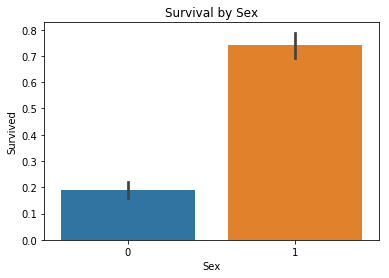

In [217]:
sns.barplot(x='Sex', y='Survived', data=train)
plt.title('Survival by Sex');

Proportion of first class which survived: 0.6261682242990654
Proportion of second class which survived: 0.47282608695652173
Proportion of third class which survived: 0.24236252545824846


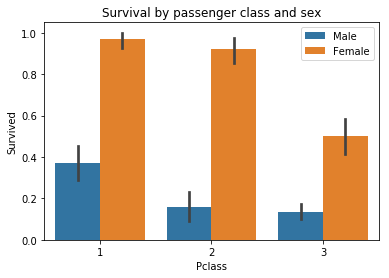

In [236]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train)
plt.title('Survival by passenger class and sex');

leg = plt.legend()

leg.get_texts()[0].set_text('Male')
leg.get_texts()[1].set_text('Female')

first_class_survived = train[train['Pclass'] == 1].Survived.mean()
second_class_survived = train[train['Pclass'] == 2].Survived.mean()
third_class_survived = train[train['Pclass'] == 3].Survived.mean()

print('Proportion of first class which survived: {}'.format(first_class_survived))
print('Proportion of second class which survived: {}'.format(second_class_survived))
print('Proportion of third class which survived: {}'.format(third_class_survived))

In [225]:
train.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked'], dtype=object)

## Logistic regression

In [191]:
from sklearn.linear_model import LogisticRegression

In [192]:
logmodel = LogisticRegression()

Now train the model using our training data.

In [193]:
logmodel.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Make predictions using the trained model.

In [194]:
predictions = logmodel.predict(x_test)

In [195]:
p = pd.DataFrame(data={'PassengerId': test['PassengerId'], 'Survived': predictions})

In [196]:
p.to_csv('predictions.csv', index=False)

In [197]:
p.Survived.mean()

0.37320574162679426

## Let's give KNN a try.

In [198]:
from sklearn.neighbors import KNeighborsClassifier

In [199]:
knn_model = KNeighborsClassifier(n_neighbors=3, algorithm='kd_tree', metric='minkowski')

In [200]:
knn_model.fit(x_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [201]:
knn_predictions = knn_model.predict(x_test)

In [202]:
knn_df = pd.DataFrame(data={'PassengerId': test['PassengerId'], 'Survived': knn_predictions})

In [203]:
knn_df.to_csv('knn_predict.csv', index=False)

In [204]:
knn_df.Survived.mean()

0.41866028708133973

In [205]:
knn_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,1
4,896,0


## Let's try random forest

In [206]:
from sklearn.ensemble import RandomForestClassifier

In [207]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [208]:
rfc_predictions = rfc.predict(x_test)

In [209]:
rfc_df = pd.DataFrame(data={'PassengerId': test.PassengerId, 'Survived': rfc_predictions})

In [210]:
rfc_df.to_csv('rfc_predict.csv', index=False)

In [211]:
rfc_df.Survived.mean()

0.3708133971291866